Train a Baseline Model

In [19]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.linear_model import LinearRegression
import joblib
from flask import Flask, request, render_template
import os



In [20]:
# Loading in the data
data = pd.read_csv("SS_Final_cleaned.csv")

In [21]:
# Train test split
X = data.drop(columns='price/sqm')
y = data['price/sqm']

# Split the data into a training set and a test set with a 80-20 split. Use a random state of 42 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Create a pipeline, seperate numerical and categorical columns
categorical_features = X.select_dtypes(include = ["object"]).columns.to_list()
numerical_features = X.select_dtypes(include = ["float", "int"]).columns.to_list() 

# Create the pipelines
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  
])

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])


# Combine the pipelines
preprocessor = ColumnTransformer([
    ('categorical', categorical_pipeline, categorical_features),
    ('numerical', numerical_pipeline, numerical_features)
    ])

4. XGBoost

In [23]:
# Create a pipeline that includes the preprocessor and the XGBoost model
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:absoluteerror', colsample_bytree=0.5, learning_rate=0.05,
                                   max_depth=6, alpha=15, n_estimators=200))
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [4, 6, 8],
    'regressor__n_estimators': [100, 200, 300],
    'regressor__colsample_bytree': [0.3, 0.5, 0.7],
    'regressor__alpha': [10, 15, 20]
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2 Score: {r2}')
print(f'Best Parameters: {grid_search.best_params_}')

Mean Squared Error: 20.335035202918522
Mean Absolute Error: 3.1455368983186056
R^2 Score: 0.42130766012829135
Best Parameters: {'regressor__alpha': 10, 'regressor__colsample_bytree': 0.7, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 8, 'regressor__n_estimators': 300}


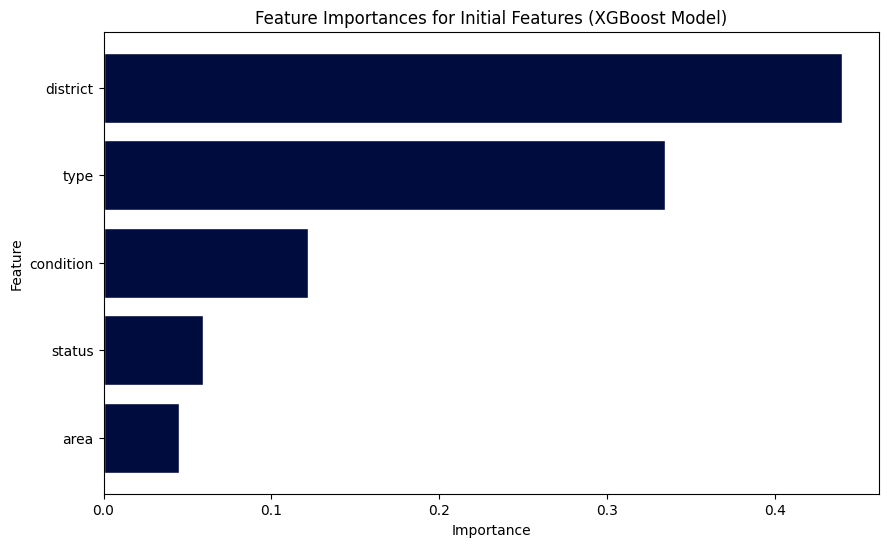

In [24]:
# Ensure the preprocessor is fitted
preprocessor.fit(X_train)

# Extract feature importances
feature_importances = best_model.named_steps['regressor'].feature_importances_

# Get feature names from the preprocessor
# Adjust the transformer names and indices as per the structure in Primary model.ipynb
onehot_columns = preprocessor.named_transformers_['categorical'].named_steps['encoder'].get_feature_names_out(preprocessor.transformers_[0][2])
numeric_columns = preprocessor.transformers_[1][2]
encoded_feature_names = np.concatenate([onehot_columns, numeric_columns])

# Map encoded features to original features
original_feature_names = preprocessor.transformers_[0][2] + preprocessor.transformers_[1][2]
feature_importance_dict = {feature: 0 for feature in original_feature_names}

# Aggregate importances
for feature, importance in zip(encoded_feature_names, feature_importances):
    original_feature = feature.split('_')[0]  # Assuming one-hot encoded features are in the format 'feature_value'
    feature_importance_dict[original_feature] += importance

# Create a DataFrame for better visualization
features_df = pd.DataFrame({
    'Feature': list(feature_importance_dict.keys()),
    'Importance': list(feature_importance_dict.values())
})

# Sort the DataFrame by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(features_df['Feature'], features_df['Importance'], color='#000C3D', edgecolor='white')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Initial Features (XGBoost Model)')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

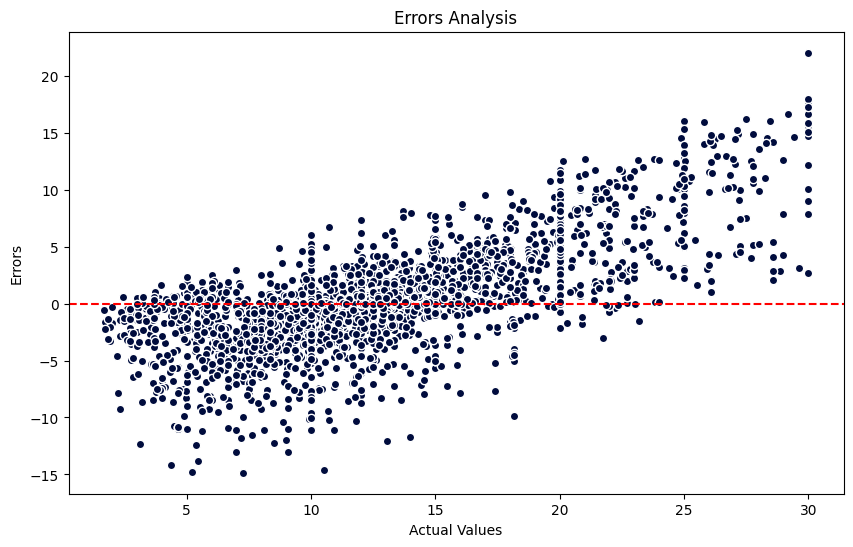

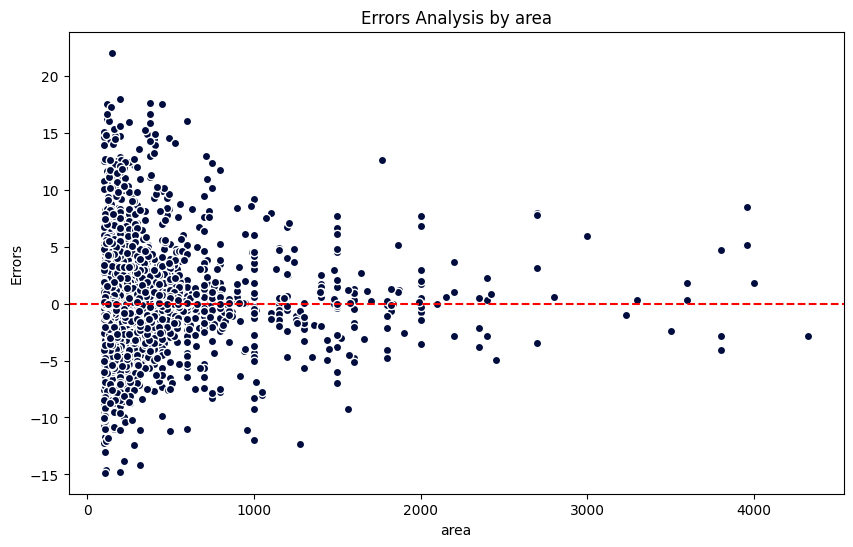

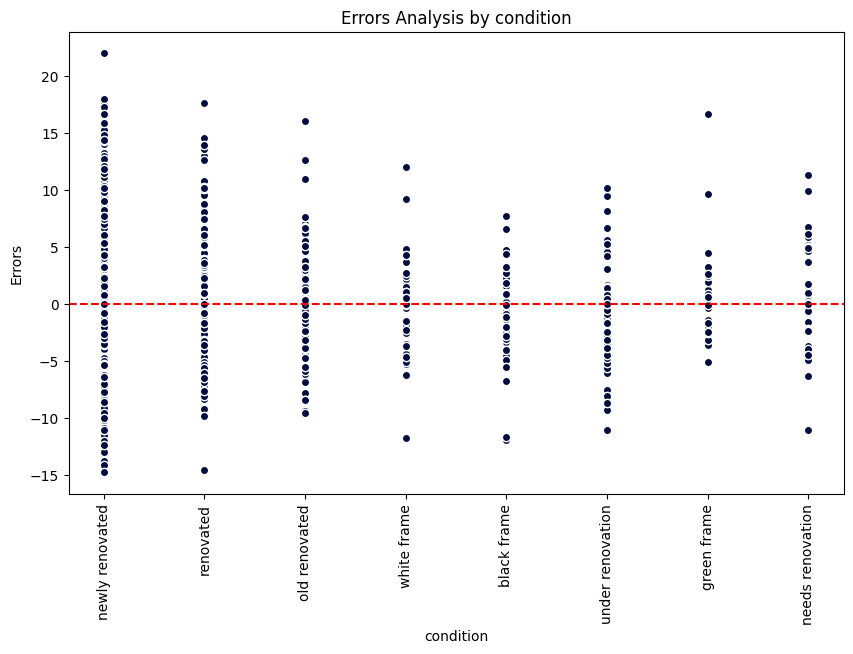

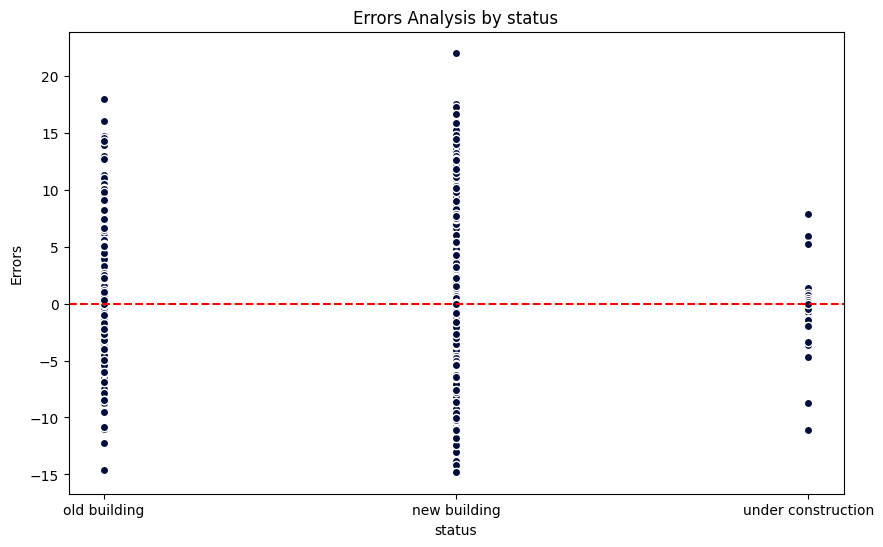

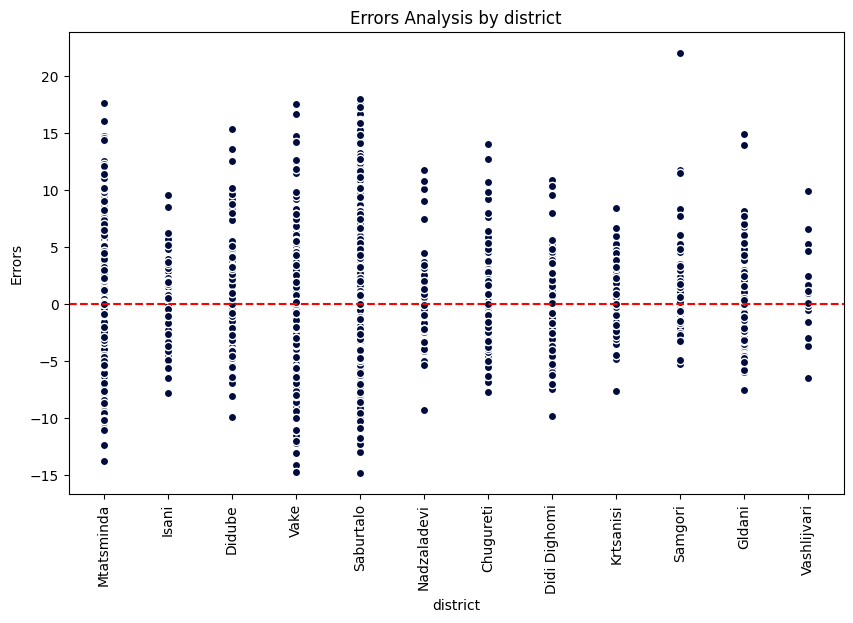

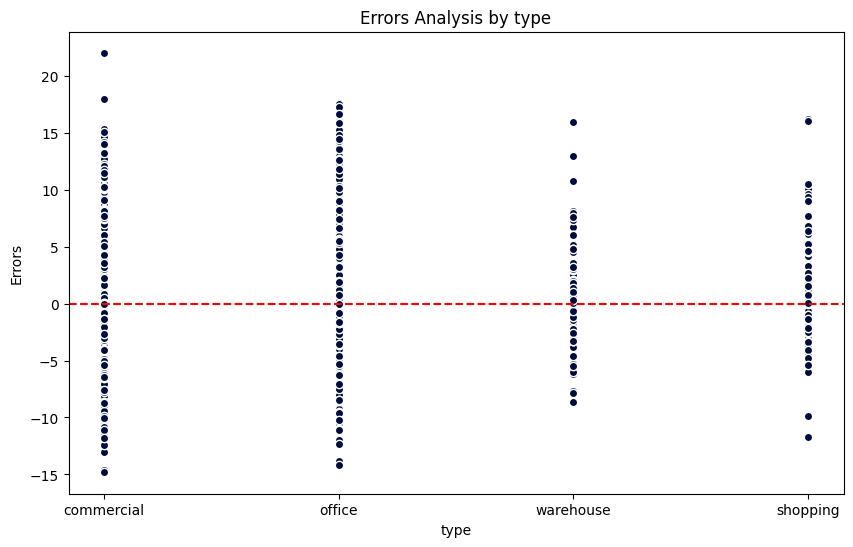

In [27]:
# Get predictions
y_pred = best_model.predict(X_test)

# Calculate errors
errors = y_test - y_pred

# Create a DataFrame for better visualization
errors_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Error': errors
})

# Plot the errors
plt.figure(figsize=(10, 6))
plt.scatter(y_test, errors, color='#000C3D', edgecolor='white')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Errors')
plt.title('Errors Analysis')
plt.show()

# Analyze errors by feature
for feature in X_test.columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test[feature], errors, color='#000C3D', edgecolor='white')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel(feature)
    plt.ylabel('Errors')
    plt.title(f'Errors Analysis by {feature}')
    
    # Rotate x-axis labels for 'district' and 'condition'
    if feature in ['district', 'condition']:
        plt.xticks(rotation=90)
    
    plt.show()

In [26]:
#save the model
joblib.dump(best_model, 'xgboost_model.pkl')

['xgboost_model.pkl']